<img src="https://github.com/akthammomani/akthammomani/assets/67468718/8d1f93b4-2270-477b-bd76-f9ec1c075307" width="1700"/>

# Modeling: AI-Powered Heart Disease Risk Assessment

* **Name:** Aktham Almomani
* **Course:** Probability and Statistics for Artificial Intelligence (MS-AAI-500-02) / University Of San Diego
* **Semester:** Summer 2024
* **Group:** 8

<center>
    <img src="https://github.com/akthammomani/AI_powered_heart_disease_risk_assessment_app/assets/67468718/e457d8ec-3f3d-4580-ae6e-bac3329ba681" alt="modeling">
</center>



## **Contents**<a is='Contents'></a>
* [Introduction](#Introduction)
* [Dataset](#Dataset)
* [Setup and Preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
  * [Necessary Functions](#Necessary_Functions)
* [Importing dataset](#Importing_dataset)
* [Validating the dataset](#Validating_the_dataset)
* [Heart Disease related features](#Heart_Disease_related_features)
* [Converting features data type](#Converting_features_data_type)
* [Heart Disease: Target Variable](#Heart_Disease_Target_Variable)
* [Features Selection](#Features_Selection)
* [Categorical Encoding with Catboost](#Categorical_Encoding_with_Catboost)
* [Split data into training and testing sets](#Split_data_into_training_and_testing_sets)
* [Scale features for Logistic Regression](#Scale_features_for_Logistic_Regression)
* [Baseline Modeling](#Baseline_Modeling)
  * [Class-specific level Metrics Comparison](#class_specific_level_Metrics_Comparison)
  * [Class-specific level Metrics Summary](#Class_specific_level_Metrics_Summary)
* [Model Selection](#Model_Selection)
* [Hyperparameter Tuning using Optuna](#Hyperparameter_Tuning_using_Optuna)
* [Fitting Best Model (Tuned)](#Fitting_Best_Model_tuned)
* [Tuned Best Model Features Importance Using SHAP](#Tuned_Best_Model_Features_Importance_using_SHAP)
* [Saving Final Model](#Saving_Final_Model)

## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

In this notebook, we will be fitting and evaluating multiple machine learning models to classify heart disease:

* Logistic Regression
* Random Forest
* XGBoost
* LightGBM
* Balanced Bagging
* Easy Ensemble
* Balanced Random Forest	
* Balanced Bagging (LightGBM): Balanced Bagging as a Wrapper and LightGBM as a base estimator
* Easy Ensemble (LightGBM): Easy Ensemble as a Wrapper and LightGBM as a base estimator	
  
Our goal is to accurately predict heart disease risk using these models. We will employ hyperparameter tuning with `Optuna` to optimize each model's performance. Additionally, we will leverage the `BalancedRandomForestClassifier`, `BalancedBaggingClassifier` and `EasyEnsembleClassifier` from the `imbalanced-learn library` to address class imbalance. These classifiers use bootstrapped sampling to balance the dataset, ensuring robust classification of minority classes. By focusing on underrepresented data, it enhances model performance, making it particularly suitable for imbalanced datasets like heart disease prediction.

Through this comprehensive approach, we aim to develop a reliable and effective model for heart disease risk assessment, contributing to better health outcomes.


## **Dataset**<a id='Dataset'></a>
[Contents](#Contents)

The dataset used in this Modeling notebook is the result of a comprehensive data wrangling process. Data wrangling is a crucial step in the data science workflow, involving the transformation and preparation of raw data into a more usable format. The main tasks performed during data wrangling included:

* Dealing with missing data
* Data mapping
* Data cleaning
* Feature engineering
  
These steps ensured that the dataset is well-prepared for analysis and modeling, enabling us to build reliable and robust models for heart disease prediction.



## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [26]:
#Let's import the necessary packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from scipy.stats import gamma, linregress
from bs4 import BeautifulSoup
import re

# Machine Learning models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import category_encoders as ce 
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report
import shap

# Hyperparameter tuning
import optuna

# Handling class imbalance
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced

# let's run below to customize notebook display:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# format floating-point numbers to 2 decimal places: we'll adjust below requirement as needed for specific answers during this assignment:
#pd.set_option('float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost')
warnings.filterwarnings('ignore', category=FutureWarning, module='imblearn')

### **Necessary  functions**<a id='Necessary_Functions'></a>
[Contents](#Contents)

In [2]:
def summarize_df(df):
    """
    Generate a summary DataFrame for an input DataFrame.   
    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.
    Returns:
    A datafram: containing the following columns:
              - 'unique_count': No. unique values in each column.
              - 'data_types': Data types of each column.
              - 'missing_counts': No. of missing (NaN) values in each column.
              - 'missing_percentage': Percentage of missing values in each column.
    """
    # No. of unique values for each column:
    unique_counts = df.nunique()    
    # Data types of each column:
    data_types = df.dtypes    
    # No. of missing (NaN) values in each column:
    missing_counts = df.isnull().sum()    
    # Percentage of missing values in each column:
    missing_percentage = 100 * df.isnull().mean()    
    # Concatenate the above metrics:
    summary_df = pd.concat([unique_counts, data_types, missing_counts, missing_percentage], axis=1)    
    # Rename the columns for better readibility
    summary_df.columns = ['unique_count', 'data_types', 'missing_counts', 'missing_percentage']   
    # Return summary df
    return summary_df
#-----------------------------------------------------------------------------------------------------------------#
# Function to clean and format the label
def clean_label(label):
    # Replace any non-alphabetic or non-numeric characters with nothing
    label = re.sub(r'[^a-zA-Z0-9\s]', '', label)
    # Replace spaces with underscores
    label = re.sub(r'\s+', '_', label)
    return label

#-----------------------------------------------------------------------------------------------------------------#
def value_counts_with_percentage(df, column_name):
    # Calculate value counts
    counts = df[column_name].value_counts(dropna=False)
    
    # Calculate percentages
    percentages = df[column_name].value_counts(dropna=False, normalize=True) * 100
    
    # Combine counts and percentages into a DataFrame
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })
    
    return result

#-----------------------------------------------------------------------------------------------------------------#

def plot_heart_disease_distribution(df, target):
    """
    Plots a horizontal stacked bar chart for the target variable 'Heart Disease'.
    """
    # Create a crosstab
    crosstab = pd.crosstab(df[target], df[target])

    # Plot
    fig, ax = plt.subplots(figsize=(16, 6))  # Increase the width of the figure
    crosstab.plot(kind='barh', stacked=True, color=['green', 'red'], ax=ax)
    ax.set_title(f'{target} Distribution')
    ax.set_xlabel('Count')
    ax.set_ylabel(target)
    ax.grid(True, axis='x')
    ax.set_axisbelow(True)  # Grid lines behind bars

    # Add labels outside the bars
    for i in range(len(crosstab)):
        total = sum(crosstab.iloc[i])
        label_no = f"No({crosstab.iloc[i, 0] / 1000:.1f}K)"
        label_yes = f"Yes({crosstab.iloc[i, 1] / 1000:.1f}K)"
        ax.text(total + 5000, i, f'{label_no}, {label_yes}', ha='left', va='center', color='black')

    # Adjust the limits to ensure labels fit
    ax.set_xlim(right=ax.get_xlim()[1] + 100000)

    # Move the legend outside of the plot area
    ax.legend(title=target, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Ensure labels and plot area fit within the figure
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()



## **Importing dataset**<a id='Importing_dataset'></a>
[Contents](#Contents)

In [3]:
#First, let's load the cleaned dataset "Data Wrangling output dataset":
df = pd.read_csv('brfss2022_data_wrangling_output.csv')

## **Validating The Dataset**<a id='Validating_the_dataset'></a>
[Contents](#Contents)

In [4]:
# Now, let's look at the top 5 rows of the df:
df.head()

,heart_disease,gender,race,general_health,health_care_provider,could_not_afford_to_see_doctor,length_of_time_since_last_routine_checkup,ever_diagnosed_with_heart_attack,ever_diagnosed_with_a_stroke,ever_told_you_had_a_depressive_disorder,ever_told_you_have_kidney_disease,ever_told_you_had_diabetes,BMI,difficulty_walking_or_climbing_stairs,physical_health_status,mental_health_status,asthma_Status,smoking_status,binge_drinking_status,exercise_status_in_past_30_Days,age_category,sleep_category,drinks_category
0,no,female,white_only_non_hispanic,very_good,yes_only_one,no,past_year,no,no,no,no,yes,overweight_bmi_25_to_29_9,no,zero_days_not_good,zero_days_not_good,never_asthma,never_smoked,no,no,Age_80_or_older,normal_sleep_6_to_8_hours,did_not_drink
1,no,male,white_only_non_hispanic,excellent,more_than_one,no,never,no,no,no,no,no,overweight_bmi_25_to_29_9,no,zero_days_not_good,zero_days_not_good,never_asthma,never_smoked,no,no,Age_80_or_older,normal_sleep_6_to_8_hours,did_not_drink
2,no,male,white_only_non_hispanic,very_good,yes_only_one,no,past_year,no,no,no,no,no,overweight_bmi_25_to_29_9,no,1_to_13_days_not_good,1_to_13_days_not_good,never_asthma,never_smoked,no,yes,Age_55_to_59,short_sleep_4_to_5_hours,did_not_drink
3,no,female,white_only_non_hispanic,excellent,yes_only_one,no,past_year,no,no,no,no,no,normal_weight_bmi_18_5_to_24_9,no,zero_days_not_good,zero_days_not_good,current_asthma,current_smoker_some_days,no,yes,Age_70_to_74,normal_sleep_6_to_8_hours,did_not_drink
4,no,male,white_only_non_hispanic,fair,more_than_one,no,past_year,no,no,no,no,no,normal_weight_bmi_18_5_to_24_9,no,1_to_13_days_not_good,zero_days_not_good,never_asthma,never_smoked,no,yes,Age_40_to_44,long_sleep_9_to_10_hours,low_consumption_1.01_to_5_drinks


In [5]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 445132 
Number of columns: 23


## **Heart Disease related features**<a id='Heart_Disease_related_features'></a>
[Contents](#Contents)

After several days of research and analysis of the dataset's features, we have identified the following key features for heart disease assessment:

* **Target Variable (Dependent Variable):**
    * Heart_disease: "Ever_Diagnosed_with_Angina_or_Coronary_Heart_Disease"
* **Demographics:**
    * Gender: Are_you_male_or_female
    * Race: Computed_race_groups_used_for_internet_prevalence_tables
    * Age: Imputed_Age_value_collapsed_above_80
* **Medical History:**
    * General_Health
    * Have_Personal_Health_Care_Provider
    * Could_Not_Afford_To_See_Doctor
    * Length_of_time_since_last_routine_checkup
    * Ever_Diagnosed_with_Heart_Attack
    * Ever_Diagnosed_with_a_Stroke
    * Ever_told_you_had_a_depressive_disorder
    * Ever_told_you_have_kidney_disease
    * Ever_told_you_had_diabetes
    * Reported_Weight_in_Pounds
    * Reported_Height_in_Feet_and_Inches
    * Computed_body_mass_index_categories
    * Difficulty_Walking_or_Climbing_Stairs
    * Computed_Physical_Health_Status
    * Computed_Mental_Health_Status
    * Computed_Asthma_Status
* **Life Style:**
    * Leisure_Time_Physical_Activity_Calculated_Variable
    * Smoked_at_Least_100_Cigarettes
    * Computed_Smoking_Status
    * Binge_Drinking_Calculated_Variable
    * Computed_number_of_drinks_of_alcohol_beverages_per_week
    * Exercise_in_Past_30_Days
    * How_Much_Time_Do_You_Sleep


In [6]:
#let's run below to examin each features again missing data count & percentage, unique count, data types:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
heart_disease,2,object,0,0.0
gender,3,object,0,0.0
race,7,object,0,0.0
general_health,5,object,0,0.0
health_care_provider,3,object,0,0.0
could_not_afford_to_see_doctor,2,object,0,0.0
length_of_time_since_last_routine_checkup,5,object,0,0.0
ever_diagnosed_with_heart_attack,2,object,0,0.0
ever_diagnosed_with_a_stroke,2,object,0,0.0
ever_told_you_had_a_depressive_disorder,2,object,0,0.0


## **Converting Features Data Type**<a id='Converting_features_data_type'></a>
[Contents](#Contents)


In pandas, the object data type is used for text or mixed data. When a column contains categorical data, it's often beneficial to explicitly convert it to the category data type. Here are some reasons why:

**Benefits of Converting to Categorical Type:**
* Memory Efficiency: Categorical data types are more memory efficient. Instead of storing each unique string separately, pandas stores the categories and uses integer codes to represent the values.
* Performance Improvement: Operations on categorical data can be faster since pandas can make use of the underlying integer codes.
* Explicit Semantics: Converting to category makes the data's categorical nature explicit, improving code readability and reducing the risk of treating categorical data as continuous.

In [7]:
# Convert columns to categorical
categorical_columns = df.columns  # assuming all columns need to be categorical
df[categorical_columns] = df[categorical_columns].astype('category')

summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
heart_disease,2,category,0,0.0
gender,3,category,0,0.0
race,7,category,0,0.0
general_health,5,category,0,0.0
health_care_provider,3,category,0,0.0
could_not_afford_to_see_doctor,2,category,0,0.0
length_of_time_since_last_routine_checkup,5,category,0,0.0
ever_diagnosed_with_heart_attack,2,category,0,0.0
ever_diagnosed_with_a_stroke,2,category,0,0.0
ever_told_you_had_a_depressive_disorder,2,category,0,0.0


Alright, now all our features are categorical, let's move to the next step

## **Heart Disease: Target Variable**<a id='Heart_Disease_Target_Variable'></a>
[Contents](#Contents)

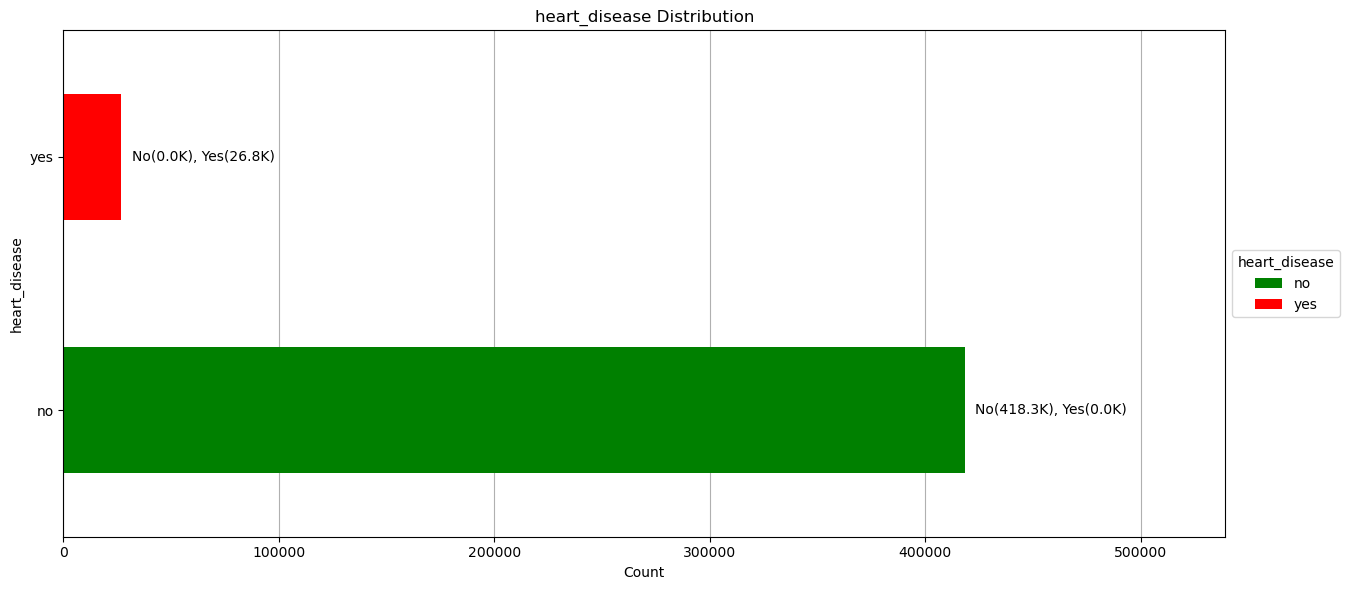

In [8]:
# Alright, now, let's look at heart disease distribution:
plot_heart_disease_distribution(df, 'heart_disease')

**Distribution Analysis**
* There is a significant imbalance between the two categories.
* A large majority of individuals do not have heart disease `418.3K`, while a much smaller number have heart disease `26.8K`.
* This imbalance can be visually observed in the chart, where the green bar is substantially longer than the red bar.

**Imbalance Issue**
* Model Bias: When training a classification model on this imbalanced dataset, the model might become biased towards predicting the majority class (No heart disease) more frequently because it is seen more often in the training data.
* Performance Metrics: Common performance metrics like accuracy can be misleading in imbalanced datasets. For instance, a model that always predicts "No heart disease" will have high accuracy because the majority class is well represented. However, this model would fail to correctly identify individuals with heart disease, which is critical for healthcare applications.
* Recall and Precision: Metrics such as recall (sensitivity) and precision are more informative in this context. Recall measures the ability to identify true positive cases (heart disease), while precision measures the accuracy of positive predictions. In an imbalanced dataset, a model might have low recall for the minority class (heart disease) even if it has high accuracy overall.

**Strategy to Address Imbalance**
The `BalancedRandomForestClassifier` or `BalancedBaggingClassifier` or `EasyEnsembleClassifier` from the `imbalanced-learn` library effectively handles class imbalance by using bootstrapped sampling to balance the dataset, ensuring robust classification of minority classes. It enhances model performance by focusing on underrepresented data, making it ideal for imbalanced datasets like heart disease prediction.

## **Features Selection**<a id='Features_Selection'></a>
[Contents](#Contents)

In [9]:
# Define the target variable:
target = 'heart_disease'

# Convert the target variable to numerical values:
df[target] = df[target].apply(lambda x: 1 if x == 'yes' else 0).astype('int')

In [10]:
df.head()

,heart_disease,gender,race,general_health,health_care_provider,could_not_afford_to_see_doctor,length_of_time_since_last_routine_checkup,ever_diagnosed_with_heart_attack,ever_diagnosed_with_a_stroke,ever_told_you_had_a_depressive_disorder,ever_told_you_have_kidney_disease,ever_told_you_had_diabetes,BMI,difficulty_walking_or_climbing_stairs,physical_health_status,mental_health_status,asthma_Status,smoking_status,binge_drinking_status,exercise_status_in_past_30_Days,age_category,sleep_category,drinks_category
0,0,female,white_only_non_hispanic,very_good,yes_only_one,no,past_year,no,no,no,no,yes,overweight_bmi_25_to_29_9,no,zero_days_not_good,zero_days_not_good,never_asthma,never_smoked,no,no,Age_80_or_older,normal_sleep_6_to_8_hours,did_not_drink
1,0,male,white_only_non_hispanic,excellent,more_than_one,no,never,no,no,no,no,no,overweight_bmi_25_to_29_9,no,zero_days_not_good,zero_days_not_good,never_asthma,never_smoked,no,no,Age_80_or_older,normal_sleep_6_to_8_hours,did_not_drink
2,0,male,white_only_non_hispanic,very_good,yes_only_one,no,past_year,no,no,no,no,no,overweight_bmi_25_to_29_9,no,1_to_13_days_not_good,1_to_13_days_not_good,never_asthma,never_smoked,no,yes,Age_55_to_59,short_sleep_4_to_5_hours,did_not_drink
3,0,female,white_only_non_hispanic,excellent,yes_only_one,no,past_year,no,no,no,no,no,normal_weight_bmi_18_5_to_24_9,no,zero_days_not_good,zero_days_not_good,current_asthma,current_smoker_some_days,no,yes,Age_70_to_74,normal_sleep_6_to_8_hours,did_not_drink
4,0,male,white_only_non_hispanic,fair,more_than_one,no,past_year,no,no,no,no,no,normal_weight_bmi_18_5_to_24_9,no,1_to_13_days_not_good,zero_days_not_good,never_asthma,never_smoked,no,yes,Age_40_to_44,long_sleep_9_to_10_hours,low_consumption_1.01_to_5_drinks


In [11]:
#let's define slect our features:
features = [ 'gender', 'race', 'general_health',
           'health_care_provider', 'could_not_afford_to_see_doctor',
           'length_of_time_since_last_routine_checkup',
           'ever_diagnosed_with_heart_attack', 'ever_diagnosed_with_a_stroke',
           'ever_told_you_had_a_depressive_disorder',
           'ever_told_you_have_kidney_disease', 'ever_told_you_had_diabetes',
           'BMI', 'difficulty_walking_or_climbing_stairs',
           'physical_health_status', 'mental_health_status', 'asthma_Status',
           'smoking_status', 'binge_drinking_status',
           'exercise_status_in_past_30_Days', 'age_category', 'sleep_category',
           'drinks_category'] 

# Separate the features and target
X = df[features]
y = df['heart_disease']

## **Categorical Encoding with Catboost**<a id='Categorical_Encoding_with_Catboost'></a>
[Contents](#Contents)

Many machine learning algorithms require data to be numeric. Therefore, before training a model or calculating the correlation (Pearson) or mutual information (prediction power), we need to convert categorical data into numeric form. Various categorical encoding methods are available, and CatBoost is one of them. CatBoost is a target-based categorical encoder. It is a supervised encoder that encodes categorical columns according to the target value, supporting both binomial and continuous targets.

Target encoding is a popular technique used for categorical encoding. It replaces a categorical feature with average value of target corresponding to that category in training dataset combined with the target probability over the entire dataset. But this introduces a target leakage since the target is used to predict the target. Such models tend to be overfitted and don’t generalize well in unseen circumstances.

A CatBoost encoder is similar to target encoding, but also involves an ordering principle in order to overcome this problem of target leakage. It uses the principle similar to the time series data validation. The values of target statistic rely on the observed history, i.e, target probability for the current feature is calculated only from the rows (observations) before it.

In [12]:
# Initialize the CatBoost encoder:
cbe_encoder = ce.CatBoostEncoder()

# Fit and transform the dataset:
cbe_encoder.fit(X,y)

# Replace the original categorical columns with encoded columns:
X_cbe = cbe_encoder.transform(X)

## **Split data into training and testing sets**<a id='Split_data_into_training_and_testing_sets'></a>
[Contents](#Contents)

In [13]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X_cbe,
                                                    y,
                                                    test_size=0.20, 
                                                    random_state=1981)

## **Scale features for Logistic Regression**<a id='Scale_features_for_Logistic_Regression'></a>
[Contents](#Contents)

In [14]:
#Scale features for Logistic Regression:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Baseline Modeling**<a id='Baseline_Modeling'></a>
[Contents](#Contents)

Here, we will fit the the following models listed below and compare their performance at the class-specific level:

* Logistic Regression
* Random Forest
* XGBoost
* LightGBM
* Balanced Bagging
* Easy Ensemble
* Balanced Random Forest	
* Balanced Bagging (LightGBM): Balanced Bagging as a Wrapper and LightGBM as a base estimator
* Easy Ensemble (LightGBM): Easy Ensemble as a Wrapper and LightGBM as a base estimator	

In [15]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=1981),
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=1981),  # Use parallel processing
    'LightGBM': LGBMClassifier(n_jobs=-1, random_state=1981),
    'XGBoost': XGBClassifier(n_jobs=-1, random_state=1981, use_label_encoder=False, eval_metric='logloss'),
    'Balanced Bagging': BalancedBaggingClassifier(random_state=1981),
    'Easy Ensemble': EasyEnsembleClassifier(random_state=1981),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=1981),
    'Balanced Bagging (LightGBM)': BalancedBaggingClassifier(estimator=LGBMClassifier(n_jobs=-1, random_state=1981), random_state=1981),
    'Easy Ensemble (LightGBM)': EasyEnsembleClassifier(estimator=LGBMClassifier(n_jobs=-1, random_state=1981), random_state=1981)
}


### **Class-specific level Metrics Comparison**<a id='class_specific_level_Metrics_Comparison'></a>
[Contents](#Contents)

In [16]:
# Create a DataFrame to store metrics
metrics_df = pd.DataFrame()

# Train and evaluate models
for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Append metrics to DataFrame using pd.concat
    model_metrics = pd.DataFrame({
        'Model': [name] * len(precision),
        'Class': list(range(len(precision))),
        'Accuracy': [accuracy] * len(precision),
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': [roc_auc] * len(precision)
    })
    metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)

metrics_df

,Model,Class,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0,0.942826,0.952530,0.988374,0.970121,0.881984
1,Logistic Regression,1,0.942826,0.573123,0.240642,0.338961,0.881984
2,Random Forest,0,0.939535,0.951774,0.985551,0.968368,0.841807
3,Random Forest,1,0.939535,0.508143,0.230131,0.316791,0.841807
4,LightGBM,0,0.943624,0.952778,0.988984,0.970543,0.884863
5,LightGBM,1,0.943624,0.589938,0.244330,0.345547,0.884863
6,XGBoost,0,0.942546,0.952736,0.987824,0.969962,0.881696
7,XGBoost,1,0.942546,0.565700,0.244514,0.341445,0.881696
8,Balanced Bagging,0,0.839273,0.975463,0.850234,0.908554,0.847909
9,Balanced Bagging,1,0.839273,0.224994,0.670293,0.336902,0.847909


### **Class-specific level Metrics Summary**<a id='Class_specific_level_Metrics_Summary'></a>
[Contents](#Contents)

* **High Recall, Low Precision and F1 Score:** The majority of models show poor recall for class 1 (patients with heart disease), except for Balanced Bagging, Easy Ensemble, Balanced Random Forest, and when these models are combined with LightGBM. This indicates that most models struggle to identify positive cases (patients with heart disease), resulting in a significant number of false negatives (patients incorrectly identified as not having heart disease).
* **Balanced Bagging and Easy Ensemble:**
  * Balanced Bagging and Easy Ensemble models, along with Balanced Random Forest, are designed to handle class imbalance by balancing the classes during training.
  * Performance:
    * They achieve higher recall for class 1, meaning they capture most of the actual positive cases.
    * The trade-off is typically lower precision, leading to a lower F1 score.
* **Medical Context Implication:** In a medical context, high recall is crucial as it is important to identify as many true positive cases as possible, even at the cost of some false positives. Missing a true positive (false negative) could be more critical than having a false positive.
* **Using LightGBM as Base Estimator:**
  * Performance with LightGBM:
    * When using LightGBM as the base estimator in Balanced Bagging and Easy Ensemble, the results show improved recall for class 1.
    * These models also have slightly better ROC AUC scores (0.885894 and 0.885778, respectively), indicating a good balance between sensitivity and specificity.
    * LightGBM is a powerful gradient boosting framework known for its efficiency and performance, which helps in achieving better overall performance metrics.
  * Improvement:
    * When using Easy Ensemble as a wrapper and LightGBM as a base estimator, the Recall for class 1 (heart disease patients) improves significantly from 24.4% (in standalone LightGBM) to 80.7%.
    * The ROC AUC improves from 88.4% to 88.6% for class 1, showing a better balance between correctly identifying true positives and minimizing false positives.
* **Practical Implications:** Heart Disease Classification Task:
  * Identifying patients with heart disease (true positives) is critical.
  * High recall is generally more desirable, even at the cost of having more false positives.
  * High Recall ensures most patients with heart disease are identified, which is crucial for early intervention and treatment.
  * False Positives, while not ideal, can be managed through follow-up testing and further medical evaluation.
* **Conclusion:**
Balanced Bagging, Easy Ensemble, and Balanced Random Forest models, particularly with LightGBM as the base estimator, provide a good balance between identifying true positives and maintaining a reasonable rate of false positives.
For a medical application such as heart disease prediction, these approaches ensure that most cases of heart disease are identified, enabling timely medical intervention, which is crucial for patient care.


## **Model Selection**<a id='Model_Selection'></a>
[Contents](#Contents)

* Based on above metrics, the **Easy Ensemble (LightGBM) model** is the best choise for the being the final model:
    * Accuracy: `0.793546`
    * Precision: `0.201685`
    * Recall: `0.807671`
    * F1 Score:`0.322771`
    * ROC AUC: `0.885778`
* **Why Easy Ensemble (LightGBM)?**
    * High Recall `(0.807671)`: This ensures we capture the majority of the true positive cases (patients with heart disease).
    * Good ROC AUC `(0.885778)`: Indicates good overall model performance in distinguishing between classes.
    * Balanced Handling of Class Imbalance: Easy Ensemble effectively manages class imbalance, which is often a challenge in medical datasets.

## **Hyperparameter Tuning using Optuna**<a id='Hyperparameter_Tuning_using_Optuna'></a>
[Contents](#Contents)


In [17]:
import time
start = time.time()
def objective(trial):
    # Define the parameter search space:
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [10, 50, 100, 500, 1000, 5000]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.2, 0.4, 0.6, 0.8, 1]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0, 0.2, 0.4, 0.6, 0.8, 1])
    }

    # Initialize the model with trial parameters:
    model = EasyEnsembleClassifier(
                                    estimator=LGBMClassifier(**params, n_jobs=-1, random_state=1981),
                                    random_state=1981
    )
    
    # Perform cross-validation and return the recall score:
    score = cross_val_score(model, X_train, y_train, scoring='recall', cv=3).mean()
    return score

# Create a study and optimize:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
end = time.time()
duration = end-start
print('\nParameters Optimization took %0.2f seconds (%0.1f minutes)'%(duration, duration/60))
# Print the best hyperparameters:
print("\nBest hyperparameters:\n ", study.best_params)

[I 2024-06-22 14:21:08,697] A new study created in memory with name: no-name-47b1e9ab-8e71-4d35-89d4-a0eb934d423f
[I 2024-06-22 14:21:35,465] Trial 0 finished with value: 0.8134530826082887 and parameters: {'n_estimators': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt', 'num_leaves': 104, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8437808863271848, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0.6}. Best is trial 0 with value: 0.8134530826082887.
[I 2024-06-22 14:33:21,173] Trial 1 finished with value: 0.8133595284872298 and parameters: {'n_estimators': 1000, 'learning_rate': 0.001, 'boosting_type': 'goss', 'num_leaves': 214, 'max_depth': 22, 'min_child_samples': 94, 'subsample': 0.5513388475010556, 'colsample_bytree': 0.6, 'reg_alpha': 0.2, 'reg_lambda': 0}. Best is trial 0 with value: 0.8134530826082887.
[I 2024-06-22 14:34:05,403] Trial 2 finished with value: 0.808026943586865 and parameters: {'n_estimators': 50, 'learning_rate': 0.05, 'boosting_type': 'dar


Parameters Optimization took 868.51 seconds (14.5 minutes)

Best hyperparameters:
  {'n_estimators': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt', 'num_leaves': 104, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8437808863271848, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0.6}


## **Fitting Best Model (Tuned)**<a id='Fitting_Best_Model_tuned'></a>
[Contents](#Contents)

In [21]:
best_params = study.best_params

# Initialize the model with the best parameters:
best_model = EasyEnsembleClassifier(
    estimator=LGBMClassifier(**best_params, n_jobs=-1, random_state=1981),
    random_state=1981
)

# Fit the model:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Create a DataFrame to store metrics
metrics_df = pd.DataFrame()

# Append metrics to DataFrame using pd.concat
model_metrics = pd.DataFrame({
    'Model': ['Easy Ensemble (LightGBM)'] * len(precision),
    'Class': list(range(len(precision))),
    'Accuracy': [accuracy] * len(precision),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': [roc_auc] * len(precision)
})
metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)
metrics_df

,Model,Class,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Easy Ensemble (LightGBM),0,0.786862,0.984788,0.785166,0.873720,0.883942
1,Easy Ensemble (LightGBM),1,0.786862,0.197094,0.813019,0.317274,0.883942


**Tuned Best Model Metrics Summary:**
* Class 0:
  * The model has a high precision `(0.984788)` for class 0, indicating that when it predicts class 0, it is correct `98.48%` of the time.
  * The recall for class 0 is also reasonably high `(0.785166)`, meaning it correctly identifies `78.52%` of all actual class 0 instances.
  * The F1 score `(0.873720)` shows a good balance between precision and recall.
  * The ROC AUC for class 0 is `0.785166`, indicating good discriminative ability.
* Class 1:
  * The precision for class 1 is low `(0.197094)`, meaning many of the predicted class 1 instances are actually class 0.
  * However, the recall for class 1 is high `(0.813019)`, indicating the model is good at identifying actual class 1 instances.
  * The F1 score for class 1 is relatively low `(0.317274)`, suggesting a trade-off between precision and recall.
  * The ROC AUC for class 1 is the same as for class 0 `(0.883942)`, indicating overall good model performance in distinguishing between classes.
    
**Comparison to Separate and Combined Models:**
* LightGBM Alone:
  * LightGBM typically has strong performance due to its gradient boosting capabilities. It may achieve high accuracy and good precision/recall balances for both classes.
  * However, LightGBM alone might struggle with class imbalance, often resulting in lower recall for minority classes (class 1: Recall `24.4%`).
* EasyEnsemble Alone:
  * EasyEnsemble without LightGBM as the base estimator focuses on balancing the data using under-sampling and creating multiple models.
  * This approach improves recall for minority classes but might not achieve the high precision that LightGBM offers.
  * The combined approach of using EasyEnsemble with LightGBM leverages the strengths of both techniques, enhancing both precision and recall, particularly for the minority class.
* Combined (Tuned):
  * When tuned, EasyEnsemble with LightGBM as the base estimator provides a balanced approach to handle class imbalance.
  * The combined method shows improved recall for class 1 ` from `24.4% to 81.3%` while maintaining a good precision for class 0 `(0.984788)`.
  * This combination also ensures that the model has a robust overall performance as indicated by the ROC AUC of `0.883942`.
    
**Conclusion:**

Using EasyEnsemble with LightGBM as the base estimator, especially when hyperparameters are tuned, offers a comprehensive solution to handling class imbalance. It ensures high precision and recall for class 0 and significantly improves recall for class 1, although precision for class 1 remains a challenge. This combined approach outperforms using LightGBM or EasyEnsemble separately by effectively leveraging the strengths of both methods.

## **Tuned Best Model Features Importance Using SHAP**<a id='Tuned_Best_Model_Features_Importance_using_SHAP'></a>
[Contents](#Contents)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


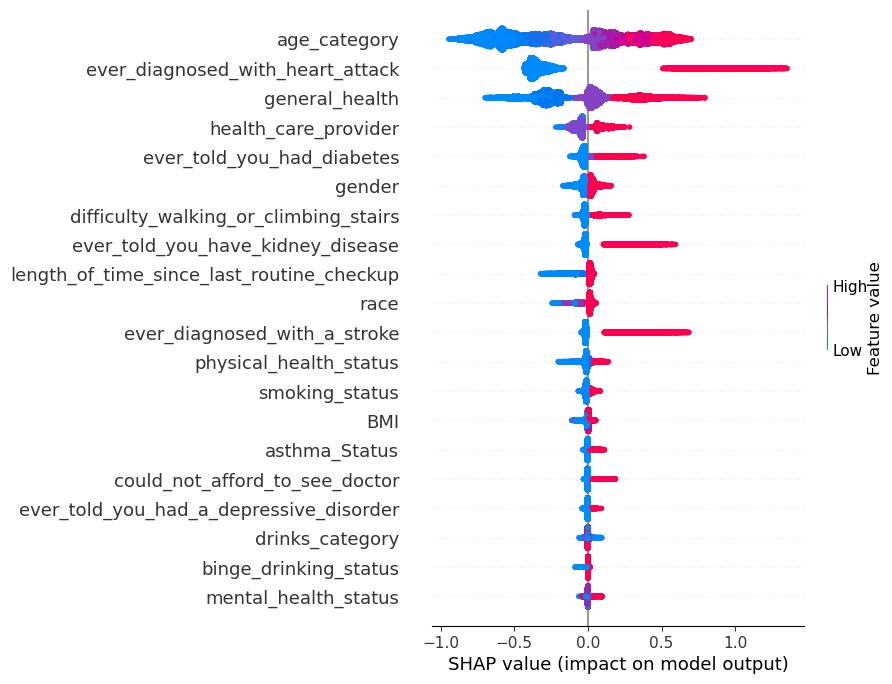

In [22]:
# Access one of the base estimators for SHAP analysis
lgbm_model = best_model.estimators_[0].steps[-1][1]

# Create a SHAP explainer for the LGBMClassifier
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for feature importance, heart disease (class 1): 
shap.summary_plot(shap_values[1], X_test, plot_size=(6,8), show=False)

**Summary of SHAP Summary Plot for Class 1 (Heart Disease Patients):**

Above SHAP summary plot shows the impact of each feature on the model's output for predicting heart disease (class 1). Each dot represents a SHAP value for a feature, with the color indicating the feature's value (red for high and blue for low). Here’s a detailed interpretation:

* **High Positive Impact:**
  * Age Category: Higher age (represented by red dots) increases the likelihood of heart disease. Age is a significant risk factor, with older individuals being more prone to heart disease.
  * Ever Diagnosed with Heart Attack: A history of heart attacks (red dots) greatly increases the likelihood of heart disease. This past medical history is a strong indicator of recurring or persistent heart issues.
* **Moderate Positive Impact:**
  * General Health: Poor general health (red dots) increases the likelihood of heart disease. Individuals with overall poor health are at higher risk.
  * Health Care Provider: Frequent visits to a healthcare provider (red dots) indicate a higher likelihood of heart disease, possibly due to ongoing health issues necessitating regular check-ups.
  * Ever Told You Had Diabetes: Being told by a healthcare provider that you have diabetes (red dots) increases the likelihood of heart disease. Diabetes is a well-known risk factor for cardiovascular diseases.
  * Gender: Certain gender-related factors (likely male, indicated by red dots) increase the likelihood of heart disease. Men generally have a higher risk of heart disease at a younger age compared to women.
  * Difficulty Walking or Climbing Stairs: Difficulty in these activities (red dots) indicates a higher risk of heart disease, possibly due to underlying cardiovascular issues.
  * Ever Told You Have Kidney Disease: A history of kidney disease (red dots) increases the likelihood of heart disease. Kidney disease can be associated with cardiovascular complications.
  * Length of Time Since Last Routine Checkup: A longer time since the last checkup (red dots) increases the likelihood of heart disease. Regular check-ups can help manage and prevent health issues.
  * Race: Certain racial factors (red dots) increase the likelihood of heart disease, highlighting the role of demographic and genetic factors.
  * Ever Diagnosed with a Stroke: A history of stroke (red dots) increases the likelihood of heart disease, as both share common risk factors.
  * Physical Health Status: Poor physical health (red dots) increases the likelihood of heart disease, reflecting the impact of overall physical well-being on heart health.
  * Smoking Status: Being a smoker (red dots) significantly increases the likelihood of heart disease. Smoking is a major risk factor for cardiovascular diseases.
  * BMI: Higher BMI (red dots) increases the likelihood of heart disease. Obesity is closely linked to cardiovascular risk.
  * Asthma Status: Higher severity of asthma (red dots) increases the risk, possibly due to the overall impact of chronic respiratory conditions on health.
  * Could Not Afford to See Doctor: Financial barriers to healthcare (red dots) increase the likelihood of heart disease, likely due to untreated health conditions.
  * Ever Told You Had a Depressive Disorder: A history of depressive disorder (red dots) increases the likelihood of heart disease, indicating a connection between mental and cardiovascular health.
  * Drinks Category: Higher alcohol consumption (red dots) is associated with an increased risk of heart disease. Excessive drinking can negatively impact heart health.
  * Binge Drinking Status: Higher frequency of binge drinking (red dots) increases the likelihood of heart disease, highlighting the adverse effects of excessive alcohol intake.
  * Mental Health Status: Poor mental health (red dots) increases the likelihood of heart disease, emphasizing the importance of mental well-being for heart health.  
* **Mixed Impact:**
  * Race: Certain racial factors have a mixed influence but can increase the likelihood of heart disease, showing the importance of considering demographic variables in health risk assessments.
  * Asthma Status: While generally having a moderate positive impact, higher severity of asthma (red dots) increases the risk of heart disease. This indicates that severe respiratory issues can contribute to cardiovascular risk.
* **Conclusion:**
The SHAP summary plot illustrates that various factors such as age, history of heart attacks, general health, and diabetes significantly impact the likelihood of heart disease. The analysis emphasizes the importance of regular health check-ups, managing chronic conditions, and addressing both physical and mental health to mitigate the risk of heart disease.

## **Saving Final Model**<a id='Saving_Final_Model'></a>

[Contents](#Contents)


Here, we'll be saving our best model: Easy Ensemble (LightGBM) and CATBoost models.


In [23]:
import pickle
import gzip, pickletools

In [24]:
# Pickling the best model:

pickle_out = open("best_model.pkl", "wb")
pickle.dump(best_model, pickle_out)
pickle_out.close()

In [25]:
pickle_out = open("cbe_encoder.pkl", "wb")
pickle.dump(cbe_encoder, pickle_out)
pickle_out.close()